In [1]:
!pip install sentence-transformers transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.2 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=7aa663351586cd0085dc7c3d0984bc3ec02ff6478861ed95f059907a6caa6419
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


# Libraries Used


In [2]:
from sentence_transformers import SentenceTransformer,util
import pandas as pd
import nltk
import re
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt

# Sentence transformers

In [3]:
xlm_model = SentenceTransformer('xlm-r-distilroberta-base-paraphrase-v1')
distilbert_model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
minilm_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Stop words 

In [4]:
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Cleaning the data

In [5]:
def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+', '', tweet)
    # Remove retweets
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # Remove punctuation
    tweet = re.sub(r'[^\w\s]', '', tweet)
    # Remove tags
    tweet = re.sub(r'@\w+', '', tweet)
    # Remove special characters
    tweet = re.sub(r'[^\x00-\x7F]+', '', tweet)
    # Remove digits
    tweet = re.sub(r'\d+', '', tweet)
    # Convert to lowercase
    tweet = tweet.lower()
    # Split the tweet into words
    words = tweet.split()
    # Remove stop words
    words = [word for word in words if word not in stop_words]
    
    # Join the words back into a string
    clean_tweet = ' '.join(words)
    
    return clean_tweet

# Calculate BERT embeddings

In [6]:
def BERT_embeddings(vectorizer,tokenizer,model):
  embeddings = []
  for feature_name in vectorizer.get_feature_names_out():
      tokens = tokenizer(feature_name, return_tensors='pt', padding=True, truncation=True)
      with torch.no_grad():
          output = model(**tokens)
      # Obtain BERT embeddings for [CLS] token
      tensor = output.last_hidden_state[:, 0, :].squeeze()
      tensor = tensor.numpy()
  #     embeddings.append(output.last_hidden_state[:, 0, :].squeeze())
      embeddings.append(tensor)
  return embeddings

# Padding


In [7]:
def padding(embeddings):
    if embeddings.shape[0] < 768:
        pad_width = ((0, 768 - embeddings.shape[0]))
        embeddings = np.pad(embeddings, pad_width=pad_width, mode='constant', constant_values=0)
    return embeddings

# Calculate cosine similarities

In [8]:
def calcSimilarity(featuresEmbeddings, stringEmbedding, df,feature_names):
    similarities = []
    for i, embedding in enumerate(featuresEmbeddings):
        similarity = util.cos_sim(embedding, stringEmbedding)
        similarities.append(similarity.squeeze().tolist())
        new_entry = {'keyphrase': feature_names[i], 'score': similarity.squeeze().tolist()}
        df.loc[len(df)] = new_entry
    return similarities

# Find embeddings from sentence tranformers

### xlm-r-distilroberta-base-paraphrase-v1

In [9]:
def xlm_similarities(combined_tweets,embeddings,dfSim,feature_names):
  combinedEmbeddingsXLM = xlm_model.encode(combined_tweets)
  combinedEmbeddingsXLM = padding(combinedEmbeddingsXLM)
  xlm_model_similarities = calcSimilarity(embeddings, combinedEmbeddingsXLM, dfSim,feature_names)
  return xlm_model_similarities

### distilbert-base-nli-stsb-mean-tokens

In [10]:
def distil_similarities(combined_tweets,embeddings,dfSim,feature_names):
  combinedEmbeddingsDistil = distilbert_model.encode(combined_tweets)
  combinedEmbeddingsDistil = padding(combinedEmbeddingsDistil)
  distil_model_similarities = calcSimilarity(embeddings, combinedEmbeddingsDistil, dfSim,feature_names)
  return distil_model_similarities

### paraphrase-MiniLM-L6-v2

In [11]:
def minilm_similarities(combined_tweets,embeddings,dfSim,feature_names):
  combinedEmbeddingsMiniLM = minilm_model.encode(combined_tweets)
  combinedEmbeddingsMiniLM = padding(combinedEmbeddingsMiniLM)
  minilm_model_similarities = calcSimilarity(embeddings, combinedEmbeddingsMiniLM, dfSim,feature_names)
  return minilm_model_similarities

# Normalized the data

In [12]:
def normalized_data(dfSim):
  # fit and transform the 'col1' column
  scaler = MinMaxScaler()
  dfSim['score_normalized'] = scaler.fit_transform(dfSim[['score']])
  dfSim = dfSim.sort_values(by='score_normalized')
  dfSim.drop('score', axis=1, inplace=True)
  return dfSim

# Eliminate insignificant keypharses using threshold and ranked by normalized score

In [13]:
def eliminate_keypharses_and_sort_by_rank(dfSim):
    # Find the standard deviation of distances
  std_dev = dfSim['score_normalized'].std()

  # Find the threshold value sigma
  mean_distance = dfSim['score_normalized'].mean()
  sigma = std_dev / mean_distance
  print(sigma)

  dfCopy = dfSim[dfSim['score_normalized'] >= sigma]

  # Rank the keyphrases based on their normalized scores using Rank Aggregation method
  df_ranked = dfCopy.sort_values(by='score_normalized', ascending=False)
  return df_ranked

# Plot time graph

In [14]:
def plot_time_taken_graph(totaltime):
  model = list(totaltime.keys())
  time = list(totaltime.values())
    
  fig = plt.figure(figsize = (5, 5))
  colors = ['b', 'g', 'r']
  # creating the bar plot
  plt.bar(model, time, color =colors,
          width = 0.1)
  
  plt.xlabel("Model Name --------->")
  plt.ylabel("Execution Time in min---------->")
  plt.title("Computational Time")
  plt.show()

# Main function 

In [15]:
def find_keypharses_from_dataset(df):
  df= df.apply(clean_tweet)
  tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
  model = AutoModel.from_pretrained('bert-base-uncased')
  vectorizer = CountVectorizer(ngram_range=(3, 3))
  X = vectorizer.fit_transform(df)
  embeddings=BERT_embeddings(vectorizer,tokenizer,model)
  data = {'keyphrase': [],
        'score': []}
  dfSim = pd.DataFrame(data)   
  feature_names = vectorizer.get_feature_names_out() 
  combined_tweets = '. '.join(df)
  starttimeforxlm=time.time()
  xlm_model_similarities=xlm_similarities(combined_tweets,embeddings,dfSim,feature_names)
  endtimeforxlm=time.time()
  starttimefordistli=time.time()
  distil_model_similarities=distil_similarities(combined_tweets,embeddings,dfSim,feature_names)
  endtimefordistli=time.time()
  starttimeformini=time.time()
  minilm_model_similarities=minilm_similarities(combined_tweets,embeddings,dfSim,feature_names)
  endtimeformini=time.time()
  totaltime={'distilbert-model':endtimefordistli-starttimefordistli,
      'xlm-model':endtimeforxlm-starttimeforxlm,
             'MiniLM-model':endtimeformini-starttimeformini}
  # create MinMaxScaler object
  
  dfSim=normalized_data(dfSim)
  df_ranked=eliminate_keypharses_and_sort_by_rank(dfSim)
  top_10 = df_ranked.drop_duplicates(subset=['score_normalized']).head(10)
  return totaltime,top_10

# DataSet-1

In [32]:
dataset="Olympics_Tokyo_tweets.csv"
max_sample_size=10

In [33]:
df = pd.read_csv(dataset)
df.dropna(inplace=True)
df.drop(df.index[max_sample_size:], inplace=True)
df = df["text"]
df= df.astype(str)

<ipython-input-33-9fe5f0bb8ba4>:1: DtypeWarning: Columns (0,4,5,6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(dataset)


In [34]:
totaltimebydataset1,top_10=find_keypharses_from_dataset(df)
print(top_10)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0.5410305679621603
                               keyphrase  score_normalized
13                 example argentina one          1.000000
63                  years old anastasija          0.988707
9   derventioexcel jacobwhittle olympics          0.974174
59                    usa men basketball          0.973814
33                     old anastasija zo          0.969349
0                 account onlyfans years          0.958398
43                 open account onlyfans          0.944858
57                teamgb incredible swim          0.941572
41                       one state chann          0.940395
45                  patty mills olympics          0.934925


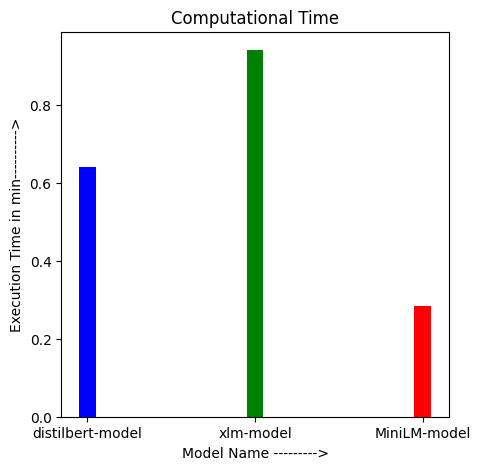

In [35]:
plot_time_taken_graph(totaltimebydataset1)


# DataSet-2

In [36]:
dataset="covid19_tweets.csv"
max_sample_size=10

In [37]:
df = pd.read_csv(dataset)
df.dropna(inplace=True)
df.drop(df.index[max_sample_size:], inplace=True)
# cols = ['id', 'text', 'user_screen_name']
df = df["text"]
df= df.astype(str)
print(df.head())

<ipython-input-37-9609282e2825>:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(dataset)


2    @diane3443 @wdunlap @realDonaldTrump Trump nev...
3    @brookbanktv The one gift #COVID19 has give me...
4    25 July : Media Bulletin on Novel #CoronaVirus...
5    #coronavirus #covid19 deaths continue to rise....
6    How #COVID19 Will Change Work in General (and ...
Name: text, dtype: object


In [38]:
totaltimebydataset2,top_10=find_keypharses_from_dataset(df)
print(top_10)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0.5183646391168987
                          keyphrase  score_normalized
17          covid give appreciation          1.000000
22    diane wdunlap realdonaldtrump          0.916795
58      realdonaldtrump trump never          0.882931
29                  gift covid give          0.863930
16              covid everyone safe          0.853145
39  logo graphicdesigner logodesign          0.842456
69           tower junction dimapur          0.841228
14                covid change work          0.837009
35              july media bulletin          0.834075
67            sundar selvaraj watch          0.831689


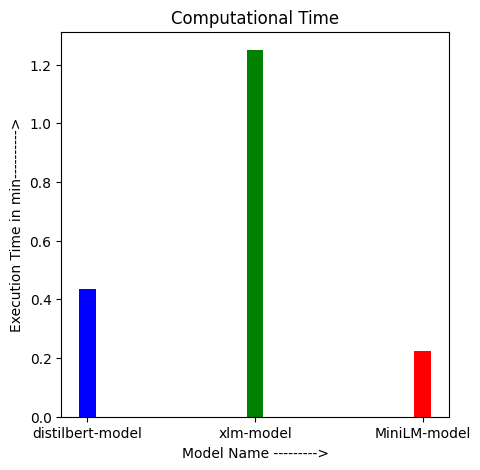

In [39]:
plot_time_taken_graph(totaltimebydataset2)

# DataSet-3

In [40]:
dataset="NEP_2020_english_tweet.csv"
max_sample_size=10

In [41]:
df = pd.read_csv(dataset)
df.dropna(inplace=True)
df.drop(df.index[max_sample_size:], inplace=True)
# cols = ['id', 'text', 'user_screen_name']
df = df["Tweet"]
df= df.astype(str)
print(df.head())

0    Historically #TamilNadu has been a state with ...
1    #HelloStrangerEP6 #HarrisonFord #GeorgeFloyd #...
2    @cbseindia29 @PMOIndia @narendramodi @DrRPNish...
3    @PMOIndia’s anti-democratic #NEP2020 was 400+ ...
4    The latest The Nursing Education Daily! http:/...
Name: Tweet, dtype: object


In [42]:
totaltimebydataset3,top_10=find_keypharses_from_dataset(df)
print(top_10)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0.45580825828529864
                                             keyphrase  score_normalized
279                       nitishkumar nep happyexolday          1.000000
62                        hindi urdu hindu_is_not_urdu          0.955030
252              kimsoohyun galaxyunpacked nitishkumar          0.954697
215                     galaxyunpacked nitishkumar nep          0.857915
270         nep happyexolday grothbeautybeautyfulenjoy          0.851117
7                                amp high stateprivate          0.849463
238                           indrajit thakurata iim_i          0.833553
192             dishasalian footballindex happyexolday          0.817588
237                         indias emergence education          0.798409
220  happyexolday grothbeautybeautyfulenjoy feeling...          0.798004


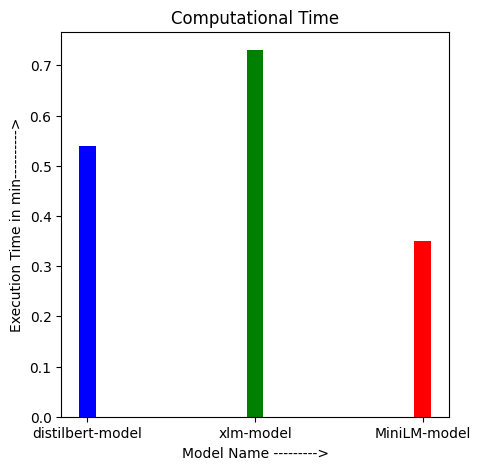

In [43]:
plot_time_taken_graph(totaltimebydataset3)

# DataSet-4

In [50]:
dataset="Human_Rights_Violation_tweets.csv"
max_sample_size=10

In [51]:
df = pd.read_csv(dataset)
df.dropna(inplace=True)
df.drop(df.index[max_sample_size:], inplace=True)
# cols = ['id', 'text', 'user_screen_name']
df = df["Text"]
df= df.astype(str)
print(df.head())

0    Few weeks back I was dancing, this cutie came ...
1    At this point if i see one more pic of paris i...
2    My teeth killing me &amp; this cold outside ma...
3    @SwagdadLevi then what is this??? https://t.co...
4    @EuroLeague @RMBaloncesto @FBBasketbol #Eurole...
Name: Text, dtype: object


In [52]:
totaltimebydataset4,top_10=find_keypharses_from_dataset(df)
print(top_10)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0.5057093754490688
                           keyphrase  score_normalized
67              shame seslini sports          1.000000
38               killing part oneini          0.962794
53              oneini ver runwayini          0.960544
69                 smoking even hurt          0.957530
37             killing machine wanna          0.957240
7            brighter cardio killing          0.956159
50  official__ini rocketeer brighter          0.947836
63         rocketeer brighter cardio          0.943904
70     softlittlecow fucking killing          0.933532
19             democrats would learn          0.933087


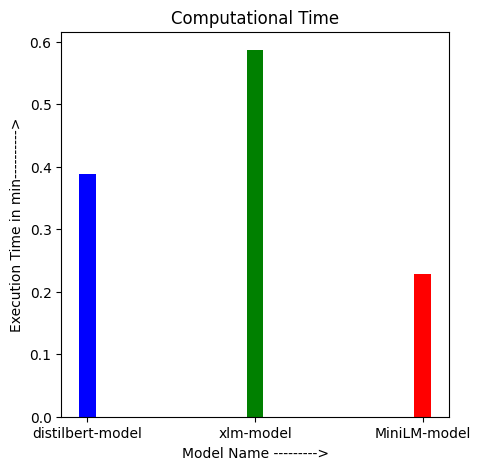

In [53]:
plot_time_taken_graph(totaltimebydataset4)

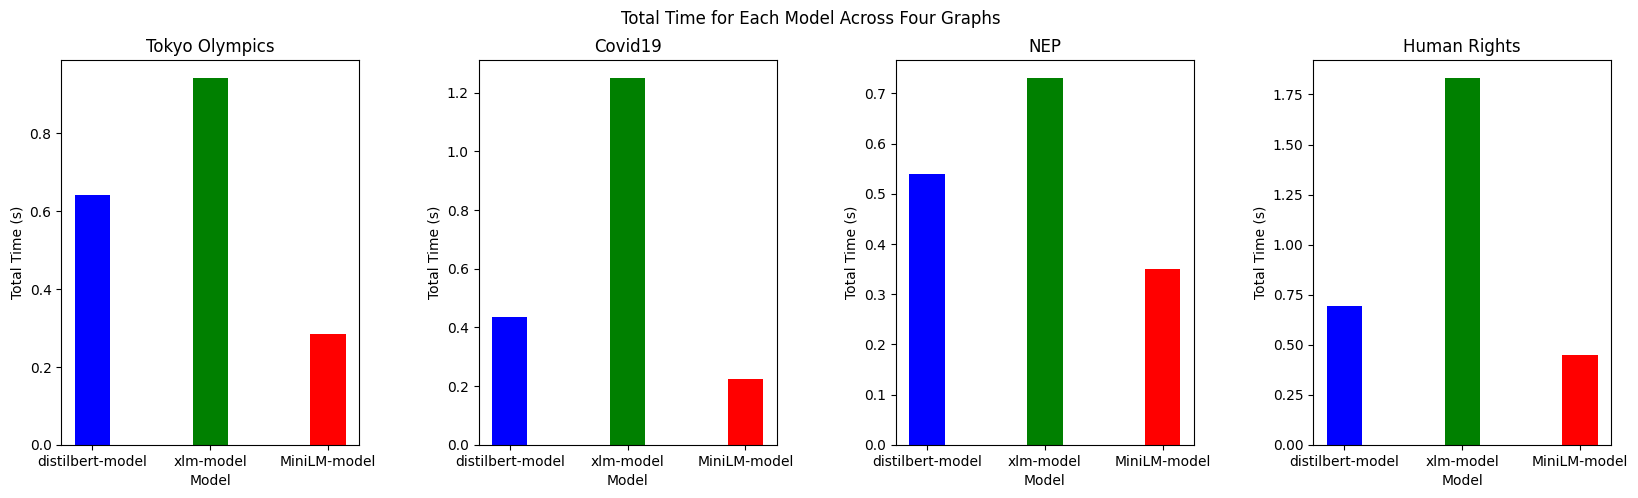

In [49]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
models = list(totaltimebydataset1.keys())
times1 = list(totaltimebydataset1.values())
times2 = list(totaltimebydataset2.values())
times3 = list(totaltimebydataset3.values())
times4 = list(totaltimebydataset4.values())
# plot each bar graph on its own axis using the bar function and set the color of each bar
colors = ['b', 'g', 'r']
for i in range(3):
    axs[0].bar(models[i], times1[i], color=colors[i],width=0.3)
    axs[0].set_title('Tokyo Olympics')
    axs[0].set_xlabel('Model')
    axs[0].set_ylabel('Total Time (s)')
    axs[1].bar(models[i], times2[i], color=colors[i],width=0.3)
    axs[1].set_title('Covid19')
    axs[1].set_xlabel('Model')
    axs[1].set_ylabel('Total Time (s)')
    axs[2].bar(models[i], times3[i], color=colors[i],width=0.3)
    axs[2].set_title('NEP')
    axs[2].set_xlabel('Model')
    axs[2].set_ylabel('Total Time (s)')
    axs[3].bar(models[i], times4[i], color=colors[i],width=0.3)
    axs[3].set_title('Human Rights')
    axs[3].set_xlabel('Model')
    axs[3].set_ylabel('Total Time (s)')

# set the title for the combined plot
fig.suptitle('Total Time for Each Model Across Four Graphs')

# adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.4)

# display the plot using the show function
plt.show()